<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/convenience_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利便性
- input:
    - convenience_store.csv
        - コンビニ店舗位置
    - supermarket.csv
        - スーパー店舗位置
    - train_station.csv
        - 最寄り駅の位置
    - train_station_route.csv
        - 主要駅までの平均所要時間
    - navitime_master.csv
        - 各種店舗の位置
    - eat_drink_master.csv
        - 飲食店の位置
- output:
    - convenience_score.csv
        - 買い物スコア
        - 駅スコア
        - 飲食店スコア
        - 利便性スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### 地理マスタ

In [5]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [6]:
store_type_list = []

### コンビニ

In [7]:
df_convini_master = pd.read_csv(os.path.join(DIR_NAME, 'convenience_store.csv'))[['name', 'lat', 'lng']]
df_convini_master['施設分類'] = 'コンビニ'
df_convini_master = df_convini_master.rename(columns={'name':'名称', 'lat':'緯度', 'lng':'経度'})
print(df_convini_master.shape)
store_type_list.append('コンビニ')

(6405, 4)


### スーパー

In [8]:
df_super_master = pd.read_csv(os.path.join(DIR_NAME, 'supermarket.csv'))[['name', 'lat', 'lng']]
df_super_master['施設分類'] = 'スーパー'
df_super_master = df_super_master.rename(columns={'name':'名称', 'lat':'緯度', 'lng':'経度'})
print(df_super_master.shape)
store_type_list.append('スーパー')

(2060, 4)


### 最寄駅

In [9]:
df_station_master = pd.read_csv(os.path.join(DIR_NAME, 'train_station.csv'))[['no', 'name', 'lat', 'lng']]
df_station_master = df_station_master.rename(columns={'no':'town_id', 'name':'最寄駅'})
print(df_station_master.shape)

(3141, 4)


### 主要駅までの平均所要時間

In [10]:
major_station = ['東京駅', '上野駅', '池袋駅', '新宿駅', '渋谷駅', '品川駅']
df_station_route = pd.read_csv(os.path.join(DIR_NAME, 'train_station_route.csv'))[['no'] + major_station].rename(columns={'no': 'town_id'})
print(df_station_route.shape)

(3141, 7)


In [11]:
df_station_route['平均所要(時間)'] = df_station_route[major_station].mean(axis=1).round(0)
df_station_route = df_station_route[['town_id', '平均所要(時間)']]

### 各種店舗
- '商店街', '銭湯', 'カラオケ', 'ネットカフェ', 'クリーニング'

In [12]:
df_navitime_org = pd.read_csv(os.path.join(DIR_NAME, 'navitime_master.csv'))[['名称', 'データ元', '緯度', '経度']]
print(df_navitime_org.shape)

df_store = df_navitime_org[
    df_navitime_org['データ元'].isin(['商店街', '銭湯', 'カラオケ', 'ネットカフェ', 'クリーニング'])
].rename(columns={'データ元': '施設分類'}).reset_index(drop=True)
print(df_store.shape)

store_type_list += list(df_store['施設分類'].unique())

(7854, 4)
(2355, 4)


### 飲食店
- 'カフェ', 'カフェ(チェーン店)', 'ファストフード', 'レストラン', 'レストラン(チェーン店)', '飲み屋'

In [13]:
df_eat_drink_org = pd.read_csv(os.path.join(DIR_NAME, 'eat_drink_master.csv'))[['名称', '施設分類', '緯度', '経度']]
df_eat_drink_org = df_eat_drink_org[
    df_eat_drink_org['施設分類'] != 'ネットカフェ'
].reset_index(drop=True)
print(df_eat_drink_org.shape)

store_type_list += list(df_eat_drink_org['施設分類'].unique())

(24260, 4)


In [14]:
df_store_master = pd.concat([
    df_convini_master,
    df_super_master,
    df_store,
    df_eat_drink_org
]).reset_index(drop=True)
print(df_store_master.shape)

(35080, 4)


In [15]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.02) &    # 約2km以内
            ((_df_cat['経度'] - lon).abs() < 0.02)      # 約2km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [16]:
%%time
radius = 0.5    # 0.5km以内の施設の数
for store in store_type_list:
    df_geo_master[f'{store}(数)'] = get_value_of_nearest_facility(df_geo_master, df_store_master, store, 'count', radius)
    print(store)

コンビニ
スーパー
商店街
銭湯
カラオケ
ネットカフェ
クリーニング
カフェ
カフェ(チェーン店)
ファストフード
レストラン
レストラン(チェーン店)
飲み屋
CPU times: user 2min 20s, sys: 1.75 s, total: 2min 22s
Wall time: 2min 37s


In [17]:
# 最寄駅からの距離
geo_master_len = len(df_geo_master)
df_geo_master = pd.merge(df_geo_master, df_station_master, on='town_id', how='left')
assert len(df_geo_master) == geo_master_len

df_geo_master['最寄駅(距離)'] = df_geo_master.apply(lambda x: get_distance(x['緯度'], x['経度'], x['lat'], x['lng']), axis=1)
df_geo_master = df_geo_master.drop(columns=['lat', 'lng'])

In [18]:
# 主要駅までの平均所要時間
df_geo_master = pd.merge(df_geo_master, df_station_route, on='town_id', how='left')
assert len(df_geo_master) == geo_master_len

max_time = df_geo_master['平均所要(時間)'].max() + 5
df_geo_master['平均所要(時間)'] = df_geo_master['平均所要(時間)'].fillna(max_time).astype(int)

In [19]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 22)


,town_id,市区町村名,町名,町丁目,緯度,経度,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅,最寄駅(距離),平均所要(時間)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,72,3,0,0,2,0,0,8,4,1,22,0,31,東京駅,0.036657,16
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,54,1,0,0,0,0,0,11,5,2,23,0,36,東京駅,0.358574,16
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,46,1,0,1,2,0,0,14,5,2,24,0,39,有楽町駅,0.219467,20
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,37,1,0,1,0,0,1,8,8,1,18,0,30,大手町駅,0.308061,20
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,45,3,0,0,0,0,2,7,7,1,18,0,25,大手町駅,0.446996,20


In [20]:
feature_list = [col for col in df_geo_master.columns if col.endswith(')')]

コンビニ(数)


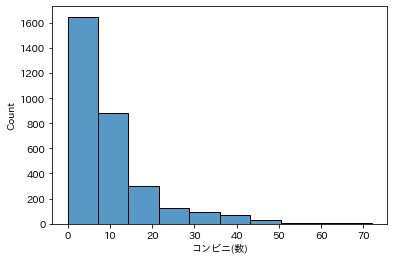

スーパー(数)


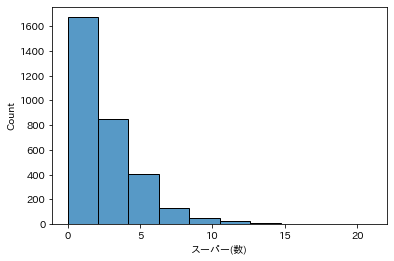

商店街(数)


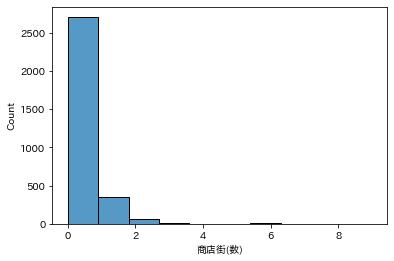

銭湯(数)


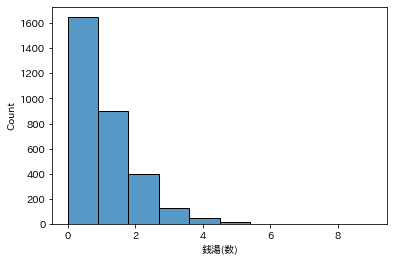

カラオケ(数)


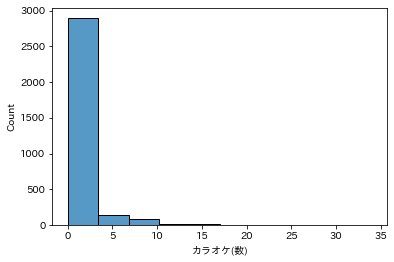

ネットカフェ(数)


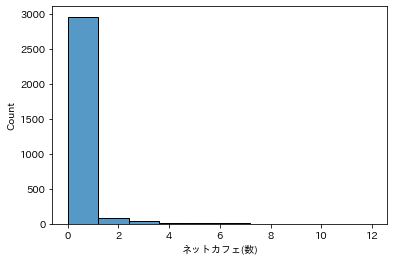

クリーニング(数)


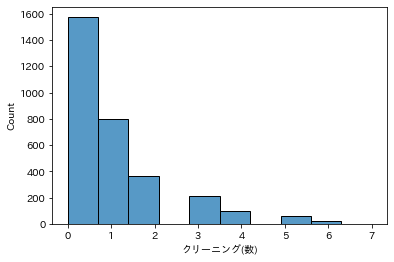

カフェ(数)


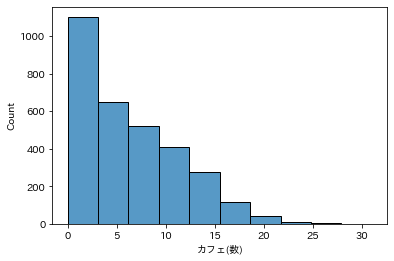

カフェ(チェーン店)(数)


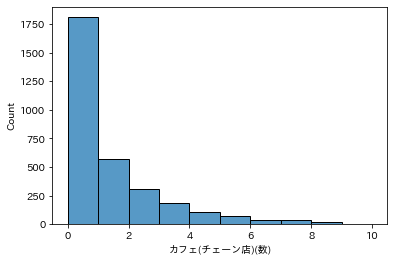

ファストフード(数)


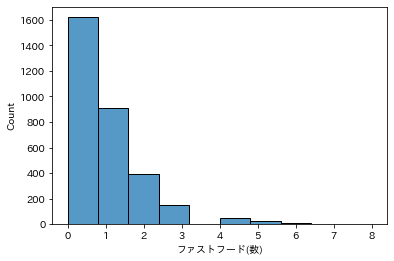

レストラン(数)


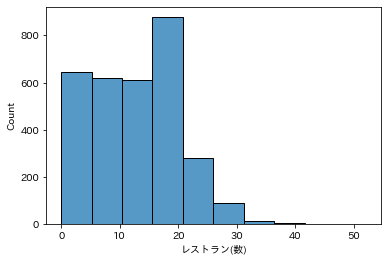

レストラン(チェーン店)(数)


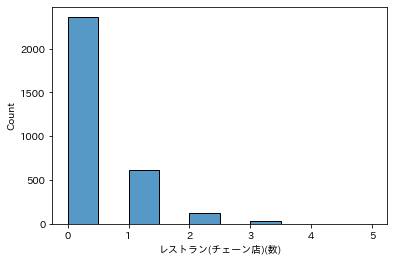

飲み屋(数)


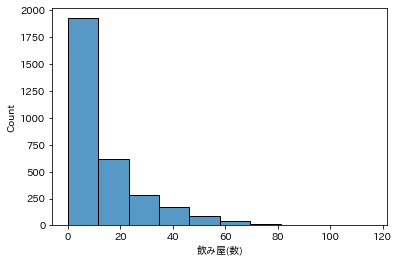

最寄駅(距離)


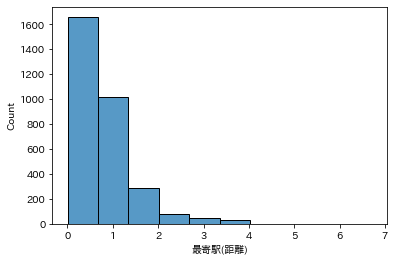

平均所要(時間)


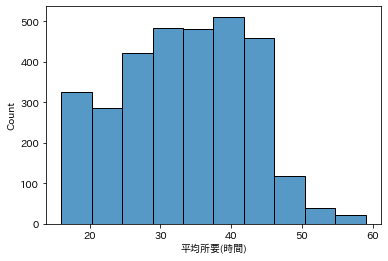

In [21]:
for feature in feature_list:
    print(feature)
    sns.histplot(df_geo_master[feature], bins=10)
    plt.show()

In [22]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

In [23]:
def plot_score(df_master, score_name, sr_source=None):
    if sr_source is not None:
        sns.histplot(sr_source, bins=20)
        plt.show()
    sns.histplot(df_master[score_name], bins=20)
    plt.show()
    print(df_master[score_name].describe())

In [24]:
for feature in feature_list:
    if feature.endswith('(距離)') or feature.endswith('(時間)'):
        df_geo_master[f'{feature}レベル'] = rank_score(df_geo_master[feature]*(-1)).round(2)
    else:
        df_geo_master[f'{feature}レベル'] = rank_score(df_geo_master[feature]).round(2)

In [25]:
feature_list

['コンビニ(数)',
 'スーパー(数)',
 '商店街(数)',
 '銭湯(数)',
 'カラオケ(数)',
 'ネットカフェ(数)',
 'クリーニング(数)',
 'カフェ(数)',
 'カフェ(チェーン店)(数)',
 'ファストフード(数)',
 'レストラン(数)',
 'レストラン(チェーン店)(数)',
 '飲み屋(数)',
 '最寄駅(距離)',
 '平均所要(時間)']

### 買い物スコア

In [26]:
score_name_list = []
score_name = '買い物スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['コンビニ(数)レベル'] * 0.5,
    df_geo_master['スーパー(数)レベル'] * 1.0,
    df_geo_master['商店街(数)レベル'] * 0.7,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

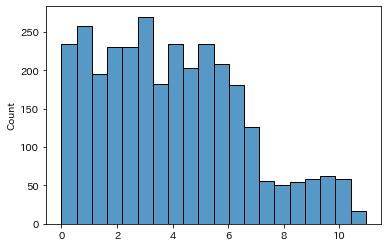

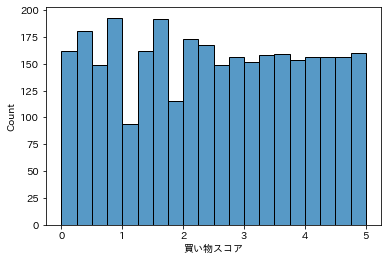

count    3145.000000
mean        2.481975
std         1.454528
min         0.000000
25%         1.250000
50%         2.480000
75%         3.740000
max         5.000000
Name: 買い物スコア, dtype: float64


In [27]:
plot_score(df_geo_master, score_name, _tmp_score)

### 駅スコア

In [28]:
score_name = '駅スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['最寄駅(距離)レベル'] * 0.7,
    df_geo_master['平均所要(時間)レベル'] * 1.0,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

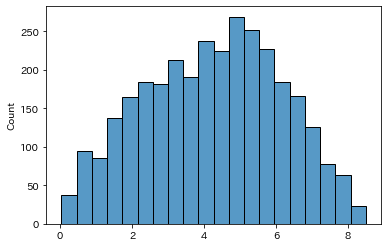

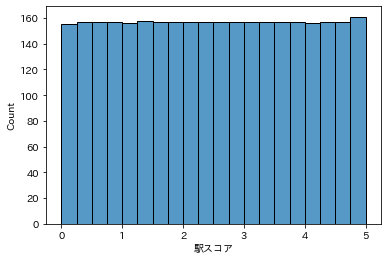

count    3141.000000
mean        2.499602
std         1.444327
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 駅スコア, dtype: float64


In [29]:
plot_score(df_geo_master, score_name, _tmp_score)

### 飲食店スコア
'カフェ(数)',
 'カフェ(チェーン店)(数)',
 'ファストフード(数)',
 'レストラン(数)',
 'レストラン(チェーン店)(数)',
 '飲み屋(数)',

In [30]:
score_name = '飲食店スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['カフェ(数)レベル'] * 0.7,
    df_geo_master['カフェ(チェーン店)(数)レベル'] * 0.7,
    df_geo_master['ファストフード(数)レベル'] * 0.5,
    df_geo_master['レストラン(数)レベル'] * 1.0,
    df_geo_master['レストラン(チェーン店)(数)レベル'] * 0.7,
    df_geo_master['飲み屋(数)レベル'] * 0.5,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

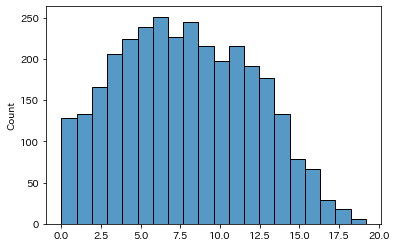

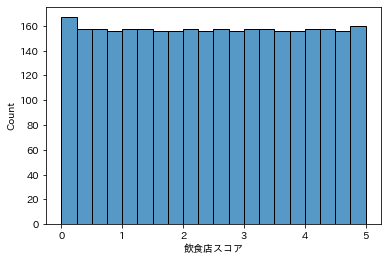

count    3145.000000
mean        2.488779
std         1.450477
min         0.000000
25%         1.230000
50%         2.490000
75%         3.740000
max         5.000000
Name: 飲食店スコア, dtype: float64


In [31]:
plot_score(df_geo_master, score_name, _tmp_score)

In [32]:
score_name = '利便性スコア'
score_name_list.append(score_name)

score_list = [
    df_geo_master['買い物スコア'] * 1.0,
    df_geo_master['駅スコア'] * 1.0,
    df_geo_master['飲食店スコア'] * 1.0,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score).round(2)

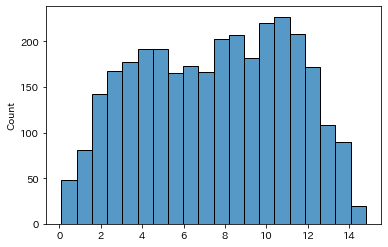

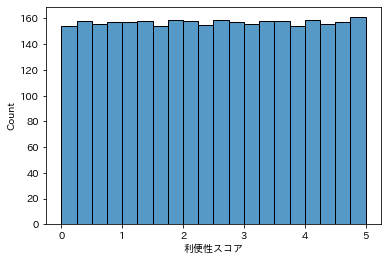

count    3141.000000
mean        2.499952
std         1.444042
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 利便性スコア, dtype: float64


In [33]:
plot_score(df_geo_master, score_name, _tmp_score)

In [34]:
df_geo_master['最寄駅(距離)'] = df_geo_master['最寄駅(距離)'].round(3)

In [35]:
df_geo_master.head()

,town_id,市区町村名,町名,町丁目,緯度,経度,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅,最寄駅(距離),平均所要(時間),コンビニ(数)レベル,スーパー(数)レベル,商店街(数)レベル,銭湯(数)レベル,カラオケ(数)レベル,ネットカフェ(数)レベル,クリーニング(数)レベル,カフェ(数)レベル,カフェ(チェーン店)(数)レベル,ファストフード(数)レベル,レストラン(数)レベル,レストラン(チェーン店)(数)レベル,飲み屋(数)レベル,最寄駅(距離)レベル,平均所要(時間)レベル,買い物スコア,駅スコア,飲食店スコア,利便性スコア
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,72,3,0,0,2,0,0,8,4,1,22,0,31,東京駅,0.037,16,5.00,2.90,0.0,0.00,3.83,0.0,0.00,3.16,4.52,2.71,4.58,0.0,4.35,4.99,5.00,3.58,5.00,4.49,4.77
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,54,1,0,0,0,0,0,11,5,2,23,0,36,東京駅,0.359,16,4.99,0.89,0.0,0.00,0.00,0.0,0.00,3.92,4.72,4.10,4.68,0.0,4.51,3.90,5.00,2.29,4.88,4.77,4.42
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,46,1,0,1,2,0,0,14,5,2,24,0,39,有楽町駅,0.219,20,4.97,0.89,0.0,2.75,3.83,0.0,0.00,4.50,4.72,4.10,4.76,0.0,4.61,4.66,4.65,2.29,4.92,4.84,4.46
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,37,1,0,1,0,0,1,8,8,1,18,0,30,大手町駅,0.308,20,4.86,0.89,0.0,2.75,0.00,0.0,2.52,3.16,4.97,2.71,3.63,0.0,4.32,4.21,4.65,2.28,4.85,4.29,4.18
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,45,3,0,0,0,0,2,7,7,1,18,0,25,大手町駅,0.447,20,4.96,2.90,0.0,0.00,0.00,0.0,3.75,2.86,4.92,2.71,3.63,0.0,4.05,3.42,4.65,3.54,4.66,4.18,4.57


In [36]:
output_score_file = 'convenience_score.csv'

In [37]:
df_geo_master[
    ['town_id'] + feature_list + score_name_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

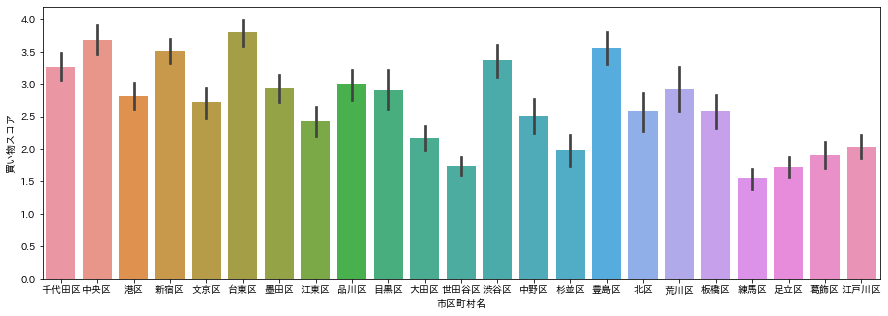

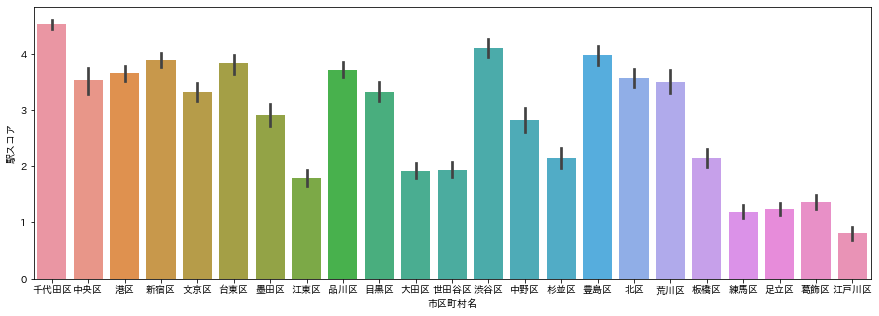

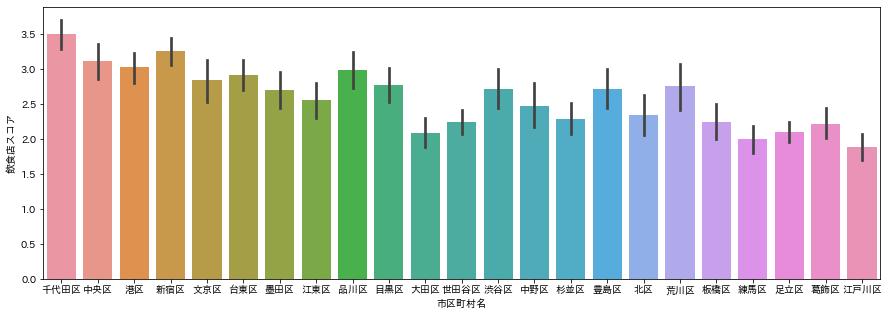

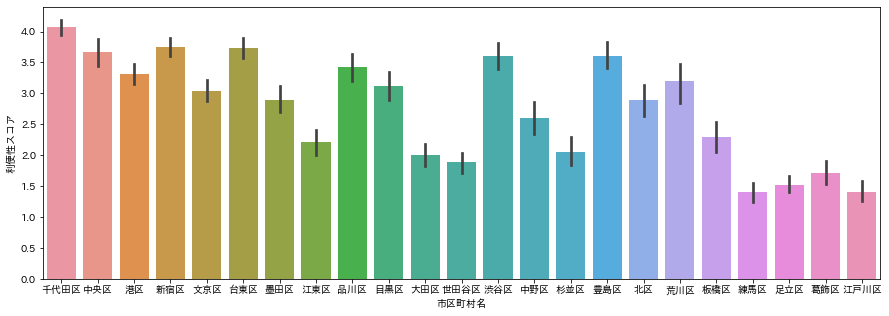

In [38]:
for score in score_name_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=score, data=df_geo_master)
    plt.show()

In [39]:
df_level = df_geo_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目', '最寄駅'] + feature_list + score_name_list
].reset_index(drop=True)
print(df_level.shape)

(901, 23)


In [40]:
df_level.head(20)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅(距離),平均所要(時間),買い物スコア,駅スコア,飲食店スコア,利便性スコア
0,新宿区,揚場町,揚場町,飯田橋駅,31,5,2,2,7,2,3,14,7,0,27,2,55,0.176,20,4.89,4.95,4.96,5.00
1,新宿区,神楽河岸,神楽河岸,飯田橋駅,33,4,2,1,7,2,1,14,7,0,17,2,52,0.184,20,4.80,4.94,4.85,5.00
2,新宿区,下宮比町,下宮比町,飯田橋駅,29,4,1,1,7,2,1,17,6,0,28,2,51,0.167,20,4.71,4.95,4.97,5.00
3,新宿区,神楽坂,神楽坂３丁目,飯田橋駅,27,8,1,2,5,1,3,14,7,0,27,2,59,0.373,20,4.92,4.77,4.96,5.00
4,新宿区,津久戸町,津久戸町,飯田橋駅,26,7,1,2,5,1,3,18,2,0,26,1,59,0.357,20,4.90,4.79,4.88,4.99
5,新宿区,大久保,大久保１丁目,新大久保駅,30,8,1,2,8,3,1,12,2,2,20,0,44,0.489,18,4.93,4.73,4.64,4.99
6,台東区,上野,上野６丁目,御徒町駅,51,12,2,2,11,10,3,12,7,1,19,0,50,0.208,21,5.00,4.88,4.63,4.99
7,荒川区,西日暮里,西日暮里３丁目,西日暮里駅,19,8,2,2,3,0,1,25,3,0,20,0,58,0.247,21,4.98,4.85,4.38,4.98
8,新宿区,高田馬場,高田馬場１丁目,高田馬場駅,28,7,0,0,3,1,4,19,5,2,20,1,69,0.333,18,4.40,4.89,4.99,4.98
9,中野区,中野,中野４丁目,中野駅,24,5,1,0,1,0,0,7,4,1,23,1,42,0.389,24,4.79,4.47,4.90,4.97


In [41]:
df_level.tail(20)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),スーパー(数),商店街(数),銭湯(数),カラオケ(数),ネットカフェ(数),クリーニング(数),カフェ(数),カフェ(チェーン店)(数),ファストフード(数),レストラン(数),レストラン(チェーン店)(数),飲み屋(数),最寄駅(距離),平均所要(時間),買い物スコア,駅スコア,飲食店スコア,利便性スコア
881,葛飾区,水元公園,水元公園,金町駅,1,0,0,0,0,0,0,0,1,0,6,1,0,2.035,42,0.08,0.25,1.67,0.33
882,練馬区,西大泉町,西大泉町,保谷駅,1,1,0,0,0,0,0,1,0,0,4,2,2,1.675,48,0.55,0.05,1.37,0.32
883,足立区,古千谷,古千谷１丁目,舎人公園駅,1,0,0,0,0,0,0,0,0,0,4,0,0,0.299,45,0.08,1.74,0.14,0.32
884,江戸川区,東篠崎,東篠崎１丁目,本八幡駅,4,0,0,0,0,0,0,1,0,0,20,0,1,2.710,43,0.39,0.14,1.38,0.30
885,大田区,多摩川河川敷,多摩川河川敷（下流）,矢口渡駅,3,0,0,0,0,0,1,1,0,0,1,0,1,0.703,39,0.28,1.43,0.15,0.29
886,江戸川区,宇喜田町,宇喜田町,葛西臨海公園駅,5,1,0,0,0,0,0,1,0,0,12,0,0,3.546,43,1.13,0.10,0.58,0.27
887,足立区,舎人公園,舎人公園,舎人公園駅,2,0,0,0,0,0,0,0,0,0,4,0,0,0.375,45,0.17,1.48,0.14,0.27
888,世田谷区,玉堤,玉堤１丁目,尾山台駅,3,1,0,0,0,0,0,0,0,0,0,0,0,1.346,38,0.84,0.87,0.00,0.25
889,足立区,神明,神明２丁目,六町駅,6,1,0,0,0,0,1,0,0,0,8,0,0,1.580,47,1.25,0.08,0.28,0.22
890,杉並区,大宮,大宮２丁目,西永福駅,0,0,0,0,0,0,0,3,0,0,3,0,0,0.692,40,0.00,1.30,0.28,0.21
